In [1]:
from pyscf import gto, scf, cc
import numpy as np
from jax import numpy as jnp
from jax import vmap, jvp, jit
import jax
from functools import partial

a = 0.74 # 2aB
nH = 2
atoms = ""
for i in range(nH):
    atoms += f"H {i*a:.5f} 0.00000 0.00000 \n"

mol = gto.M(atom=atoms, basis="sto6g", unit='A', spin=0, verbose=4)
mol.build()

mf = scf.RHF(mol)
mf.kernel()

mo = mf.stability()[0]
dm = mf.make_rdm1(mo,mf.mo_occ)
mf.kernel(dm0=dm)
mo = mf.stability()[0]
dm = mf.make_rdm1(mo,mf.mo_occ)
mf.kernel(dm0=dm)


nfrozen = 0
mycc = cc.CCSD(mf,frozen=nfrozen)
mycc.kernel()[0]

System: uname_result(system='Linux', node='yichi-thinkpad', release='4.4.0-26100-Microsoft', version='#7309-Microsoft Fri Jan 01 08:00:00 PST 2016', machine='x86_64')  Threads 12
Python 3.10.16 | packaged by conda-forge | (main, Dec  5 2024, 14:16:10) [GCC 13.3.0]
numpy 1.24.3  scipy 1.14.1  h5py 3.12.1
Date: Sat Jan 24 15:23:35 2026
PySCF version 2.8.0
PySCF path  /home/yichi/research/software/lno_pyscf
GIT HEAD (branch master) ef75f4190e4de208685670651dc6c467f72b6794

[ENV] PYSCF_EXT_PATH /home/yichi/research/software/pyscf
[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 2
[INPUT] num. electrons = 2
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = A
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 H      0.000000000000   0.000000000000   0.000000000000 AA    0.000000000000   0.000000000000   0.000000000

-0.020567780090785744

In [2]:
# example for PT2
options = {'n_eql': 3,
           'n_prop_steps': 50,
            'n_ene_blocks': 1,
            'n_sr_blocks': 5,
            'n_blocks': 10,
            'n_walkers': 300,
            'seed': 2,
            'walker_type': 'rhf',
            'trial': 'cisd/hf',
            'dt':0.005,
            'free_projection':False,
            'ad_mode':None,
            'use_gpu': False,
            }

from ad_afqmc.prop_unrestricted import prop_unrestricted
prop_unrestricted.prep_afqmc(mycc,options,chol_cut=1e-5)
# prop_unrestricted.run_afqmc(options,nproc=1)
option_file='options.bin'
import pickle
with open(option_file, 'wb') as f:
    pickle.dump(options, f)

#
# Preparing AFQMC calculation
# If you import pyscf cc modules and use MPI for AFQMC in the same script, finalize MPI before calling the AFQMC driver.
# Calculating Cholesky integrals
# Finished calculating Cholesky integrals
#
# Size of the correlation space:
# Number of electrons: (1, 1)
# Number of basis functions: 2
# Number of Cholesky vectors: 3
#


/home/yichi/research/software/cs_afqmc/ad_afqmc/pyscf_interface.py:567: RuntimeWarning: divide by zero encountered in divide
  chol_vecs[nchol + 1] = (Munu0 - R) / (delta_max) ** 0.5
/home/yichi/research/software/cs_afqmc/ad_afqmc/pyscf_interface.py:567: RuntimeWarning: invalid value encountered in divide
  chol_vecs[nchol + 1] = (Munu0 - R) / (delta_max) ** 0.5


In [3]:
import numpy as np
from jax import random
from jax import numpy as jnp
from functools import partial
from ad_afqmc import config, stat_utils
from ad_afqmc.prop_unrestricted import prop_unrestricted, sampling
import time

In [4]:
config.setup_jax()
MPI = config.setup_comm()
comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

print = partial(print, flush=True)

ham_data, ham, prop, trial, wave_data, sampler, observable, options, _ = (
    prop_unrestricted._prep_afqmc())

# Hostname: yichi-thinkpad
# System Type: Linux
# Machine Type: x86_64
# Processor: x86_64
# Hostname: yichi-thinkpad
# System Type: Linux
# Machine Type: x86_64
# Processor: x86_64
# Number of MPI ranks: 1
#
# norb: 2
# nelec: (1, 1)
#
# n_eql: 3
# n_prop_steps: 50
# n_ene_blocks: 1
# n_sr_blocks: 5
# n_blocks: 10
# n_walkers: 300
# seed: 2
# walker_type: rhf
# trial: cisd/hf
# dt: 0.005
# free_projection: False
# use_gpu: False
# n_exp_terms: 6
# orbital_rotation: True
# do_sr: True
# symmetry: False
# save_walkers: False
# ene0: 0.0
# n_batch: 1
# LNO: False
# orbE: 0
# maxError: 0.001
#


In [5]:
trial.norb = trial._guide.norb
trial.nelec = trial._guide.nelec
trial.n_batch = trial._guide.n_batch

In [6]:
### initialize propagation
seed = options["seed"]
init_walkers = None
trial_rdm1 = trial.get_rdm1(wave_data)
if "rdm1" not in wave_data:
    wave_data["rdm1"] = trial_rdm1
ham_data = ham.build_measurement_intermediates(ham_data, trial, wave_data)
ham_data = ham.build_propagation_intermediates(ham_data, prop, trial, wave_data)

prop_data = prop.init_prop_data(trial, wave_data, ham_data, init_walkers)
if jnp.abs(jnp.sum(prop_data["overlaps"])) < 1.0e-6:
    raise ValueError(
        "Initial overlaps are zero. Pass walkers with non-zero overlap."
    )
prop_data["key"] = random.PRNGKey(seed + rank)

prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
prop_data["n_killed_walkers"] = 0
otg, eg, et = trial.calc_energy_mixed(
    prop_data['walkers'], ham_data, wave_data)
eg = jnp.array(jnp.sum(eg) / prop.n_walkers)
et = jnp.array(jnp.sum(et) / prop.n_walkers)
prop_data["e_estimate"] = eg
prop_data["pop_control_ene_shift"] = prop_data["e_estimate"]

comm.Barrier()
if rank == 0:
    print(f'# Propagating with {options["n_walkers"]*size} walkers')
    print("# Equilibration sweeps:")
    print("#   Iter \t Energy_G \t Energy_T \t Walltime")
    print(f"  {0:5d} \t {eg:.6f} \t {et:.6f} \t ")
comm.Barrier()

sampler_eq = sampling.sampler_mixed(
    n_prop_steps=50, n_ene_blocks=5, n_sr_blocks=10, n_chol = sampler.n_chol)

for i,n in enumerate(range(1,options["n_eql"]+1)):
    prop_data, (wt, wp, eg, et) =\
        sampler_eq.propagate_phaseless(prop_data, ham_data, prop, trial, wave_data)

    print(f"  {n:5d} \t {eg:.6f} \t {et:.6f}")

# Propagating with 300 walkers
# Equilibration sweeps:
#   Iter 	 Energy_G 	 Energy_T 	 Walltime
      0 	 -1.145940 	 -1.125372 	 
      1 	 -1.145940 	 -1.144509
      2 	 -1.145940 	 -1.146891
      3 	 -1.145940 	 -1.144380


In [7]:
sampler = sampling.sampler_mixed(n_prop_steps=50, n_ene_blocks=3, n_sr_blocks=10, n_chol = sampler.n_chol)
nsamples = 50
wp_sp = np.empty(nsamples)
eg_sp = np.empty(nsamples)
et_sp = np.empty(nsamples)
for i,n in enumerate(range(1,nsamples+1)):
    prop_data, (wt, wp, eg, et)  =\
        sampler.propagate_phaseless(prop_data, ham_data, prop, trial, wave_data)
    wp_sp[i] = wp
    eg_sp[i] = eg
    et_sp[i] = et
    print(f"  {n:5d} \t {eg:.6f} \t {et:.6f}")

      1 	 -1.145940 	 -1.146062
      2 	 -1.145940 	 -1.145859
      3 	 -1.145940 	 -1.145226
      4 	 -1.145940 	 -1.145798
      5 	 -1.145940 	 -1.145398
      6 	 -1.145940 	 -1.145055
      7 	 -1.145940 	 -1.145448
      8 	 -1.145940 	 -1.145553
      9 	 -1.145940 	 -1.145518
     10 	 -1.145940 	 -1.145484
     11 	 -1.145940 	 -1.146665
     12 	 -1.145940 	 -1.146879
     13 	 -1.145940 	 -1.144961
     14 	 -1.145940 	 -1.145634
     15 	 -1.145940 	 -1.145236
     16 	 -1.145940 	 -1.146140
     17 	 -1.145940 	 -1.145279
     18 	 -1.145940 	 -1.146675
     19 	 -1.145940 	 -1.145182
     20 	 -1.145940 	 -1.146281
     21 	 -1.145940 	 -1.147631
     22 	 -1.145940 	 -1.146032
     23 	 -1.145940 	 -1.144626
     24 	 -1.145940 	 -1.144941
     25 	 -1.145940 	 -1.144409
     26 	 -1.145940 	 -1.146642
     27 	 -1.145940 	 -1.145935
     28 	 -1.145940 	 -1.146908
     29 	 -1.145940 	 -1.145533
     30 	 -1.145940 	 -1.146854
     31 	 -1.145940 	 -1.144833
     32 

AFQMC/Guide=CISD average = -1.1459398096416462, std = 1.0369264561865222e-09
AFQMC/Trial=RHF  average = -1.14572000030799, std = 0.00011178909873585755


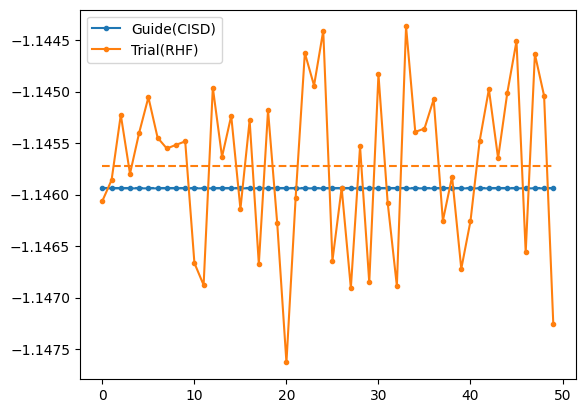

In [8]:
from matplotlib import pyplot as plt
eg_avg = eg_sp.mean()
eg_avg_std = np.std(eg_sp, ddof=1) / np.sqrt(len(eg_sp))
et_avg = np.sum(wp_sp * et_sp) / np.sum(wp_sp)
et_avg_std = np.std(et_sp, ddof=1) / np.sqrt(len(et_sp))

print(f'AFQMC/Guide=CISD average = {eg_avg}, std = {eg_avg_std}')
print(f'AFQMC/Trial=RHF  average = {et_avg}, std = {et_avg_std}')

plt.plot(eg_sp,'.-',label='Guide(CISD)',color='C0')
plt.plot([eg_avg]*len(eg_sp),'--',color='C0')
plt.plot(et_sp,'.-',label='Trial(RHF)',color='C1')
plt.plot([et_avg]*len(et_sp),'--',color='C1')

plt.legend()
plt.show()

In [9]:
# example for PT2
options = {'n_eql': 3,
           'n_prop_steps': 50,
            'n_ene_blocks': 1,
            'n_sr_blocks': 5,
            'n_blocks': 10,
            'n_walkers': 300,
            'seed': 2,
            'walker_type': 'rhf',
            'trial': 'rhf',
            'dt':0.005,
            'free_projection':False,
            'ad_mode':None,
            'use_gpu': False,
            }

from ad_afqmc.prop_unrestricted import prop_unrestricted
prop_unrestricted.prep_afqmc(mycc,options,chol_cut=1e-5)
# prop_unrestricted.run_afqmc(options,nproc=1)
option_file='options.bin'
import pickle
with open(option_file, 'wb') as f:
    pickle.dump(options, f)

#
# Preparing AFQMC calculation
# If you import pyscf cc modules and use MPI for AFQMC in the same script, finalize MPI before calling the AFQMC driver.
# Calculating Cholesky integrals
# Finished calculating Cholesky integrals
#
# Size of the correlation space:
# Number of electrons: (1, 1)
# Number of basis functions: 2
# Number of Cholesky vectors: 3
#


/home/yichi/research/software/cs_afqmc/ad_afqmc/pyscf_interface.py:567: RuntimeWarning: divide by zero encountered in divide
  chol_vecs[nchol + 1] = (Munu0 - R) / (delta_max) ** 0.5
/home/yichi/research/software/cs_afqmc/ad_afqmc/pyscf_interface.py:567: RuntimeWarning: invalid value encountered in divide
  chol_vecs[nchol + 1] = (Munu0 - R) / (delta_max) ** 0.5


In [10]:
### initialize propagation
ham_data, ham, prop, trial, wave_data, sampler, observable, options, _ = (
    prop_unrestricted._prep_afqmc())

seed = options["seed"]
init_walkers = None
trial_rdm1 = trial.get_rdm1(wave_data)
if "rdm1" not in wave_data:
    wave_data["rdm1"] = trial_rdm1
ham_data = ham.build_measurement_intermediates(ham_data, trial, wave_data)
ham_data = ham.build_propagation_intermediates(ham_data, prop, trial, wave_data)

prop_data = prop.init_prop_data(trial, wave_data, ham_data, init_walkers)
if jnp.abs(jnp.sum(prop_data["overlaps"])) < 1.0e-6:
    raise ValueError(
        "Initial overlaps are zero. Pass walkers with non-zero overlap."
    )
prop_data["key"] = random.PRNGKey(seed + rank)

prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
prop_data["n_killed_walkers"] = 0
ehf = trial.calc_energy(
    prop_data['walkers'], ham_data, wave_data)
ehf = jnp.array(jnp.sum(ehf) / prop.n_walkers)

prop_data["e_estimate"] = ehf
prop_data["pop_control_ene_shift"] = prop_data["e_estimate"]

comm.Barrier()
if rank == 0:
    print(f'# Propagating with {options["n_walkers"]*size} walkers')
    print("# Equilibration sweeps:")
    print("#   Iter \t Energy_HF \t Walltime")
    print(f"  {0:5d} \t {ehf:.6f} \t ")
comm.Barrier()

sampler_eq = sampling.sampler(n_prop_steps=50, n_ene_blocks=5, n_sr_blocks=10, n_chol = sampler.n_chol)

for i,n in enumerate(range(1,options["n_eql"]+1)):
    prop_data, (wt, ehf) =\
        sampler_eq.propagate_phaseless(ham, ham_data, prop, prop_data, trial, wave_data)

    print(f"  {n:5d} \t {wt:.6f} \t {jnp.real(ehf):.6f}")

# Hostname: yichi-thinkpad
# System Type: Linux
# Machine Type: x86_64
# Processor: x86_64
# Number of MPI ranks: 1
#
# norb: 2
# nelec: (1, 1)
#
# n_eql: 3
# n_prop_steps: 50
# n_ene_blocks: 1
# n_sr_blocks: 5
# n_blocks: 10
# n_walkers: 300
# seed: 2
# walker_type: rhf
# trial: rhf
# dt: 0.005
# free_projection: False
# use_gpu: False
# n_exp_terms: 6
# orbital_rotation: True
# do_sr: True
# symmetry: False
# save_walkers: False
# ene0: 0.0
# n_batch: 1
# LNO: False
# orbE: 0
# maxError: 0.001
#
# Propagating with 300 walkers
# Equilibration sweeps:
#   Iter 	 Energy_HF 	 Walltime
      0 	 -1.125372+0.000000j 	 
      1 	 15013.712122 	 -1.144148
      2 	 15015.410507 	 -1.147094
      3 	 15014.065225 	 -1.145109


In [11]:
sampler = sampling.sampler(n_prop_steps=50, n_ene_blocks=3, n_sr_blocks=10, n_chol = sampler.n_chol)
nsamples = 50
wt_sp = np.empty(nsamples)
ehf_sp = np.empty(nsamples)
for i,n in enumerate(range(1,nsamples+1)):
    prop_data, (wt, ehf)  =\
        sampler.propagate_phaseless(ham, ham_data, prop, prop_data, trial, wave_data)
    wt_sp[i] = wt
    ehf_sp[i] = jnp.real(ehf)
    print(f"  {n:5d} \t {wt:.6f} \t {jnp.real(ehf):.6f}")

      1 	 9009.413778 	 -1.147866
      2 	 9008.250468 	 -1.145261
      3 	 9008.502745 	 -1.145322
      4 	 9009.164349 	 -1.146153
      5 	 9008.813530 	 -1.146346
      6 	 9008.208751 	 -1.144784
      7 	 9008.828922 	 -1.145748
      8 	 9008.501992 	 -1.146172
      9 	 9008.386624 	 -1.145222
     10 	 9008.588018 	 -1.145150
     11 	 9014.470581 	 -1.159874
     12 	 9010.401222 	 -1.147510
     13 	 9008.678679 	 -1.145168
     14 	 9008.666835 	 -1.145455
     15 	 9008.743751 	 -1.145367
     16 	 9009.713490 	 -1.146360
     17 	 9008.693906 	 -1.144843
     18 	 9008.609163 	 -1.145939
     19 	 9008.076903 	 -1.144388
     20 	 9008.608008 	 -1.146153
     21 	 9009.031416 	 -1.146393
     22 	 9009.226826 	 -1.146134
     23 	 9008.478635 	 -1.145429
     24 	 9007.742986 	 -1.144732
     25 	 9008.076038 	 -1.145375
     26 	 9008.658744 	 -1.146120
     27 	 9008.991886 	 -1.145772
     28 	 9009.229321 	 -1.146155
     29 	 9008.302145 	 -1.144882
     30 	 9009

AFQMC/Guide=CISD average = -1.1459398096416462, std = 1.0369264561865222e-09
AFQMC/Trial=RHF  average = -1.14572000030799, std = 0.00011178909873585755
AFQMC/Pure_RHF  average = -1.1461845323090432, std = 0.00031602651951957364


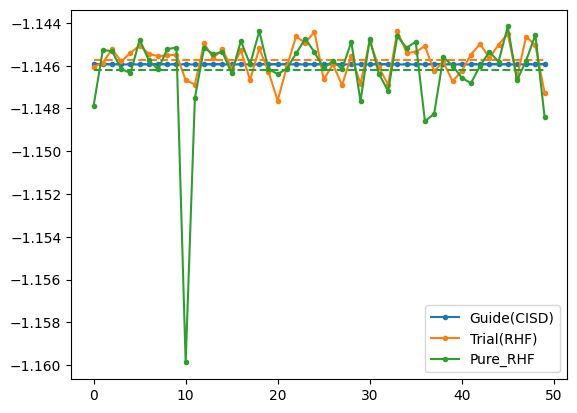

In [13]:
from matplotlib import pyplot as plt
eg_avg = eg_sp.mean()
eg_avg_std = np.std(eg_sp, ddof=1) / np.sqrt(len(eg_sp))
et_avg = np.sum(wp_sp * et_sp) / np.sum(wp_sp)
et_avg_std = np.std(et_sp, ddof=1) / np.sqrt(len(et_sp))
ehf_avg = ehf_sp.mean()
ehf_avg_std = np.std(ehf_sp, ddof=1) / np.sqrt(len(ehf_sp))

print(f'AFQMC/Guide=CISD average = {eg_avg}, std = {eg_avg_std}')
print(f'AFQMC/Trial=RHF  average = {et_avg}, std = {et_avg_std}')
print(f'AFQMC/Pure_RHF  average = {ehf_avg}, std = {ehf_avg_std}')

plt.plot(eg_sp,'.-',label='Guide(CISD)',color='C0')
plt.plot([eg_avg]*len(eg_sp),'--',color='C0')
plt.plot(et_sp,'.-',label='Trial(RHF)',color='C1')
plt.plot([et_avg]*len(et_sp),'--',color='C1')
plt.plot(ehf_sp,'.-',label='Pure_RHF',color='C2')
plt.plot([ehf_avg]*len(ehf_sp),'--',color='C2')

plt.legend()
plt.show()